Index(['Humidité (%)', 'Température (°C)', 'pH du sol', 'Précipitations (mm)',
       'Type de sol', 'Rendement agricole (t/ha)'],
      dtype='object')
Meilleures conditions trouvées :
Humidité = 33.43 %
Température = 27.76 °C
Rendement agricole optimal = 8.54 t/ha


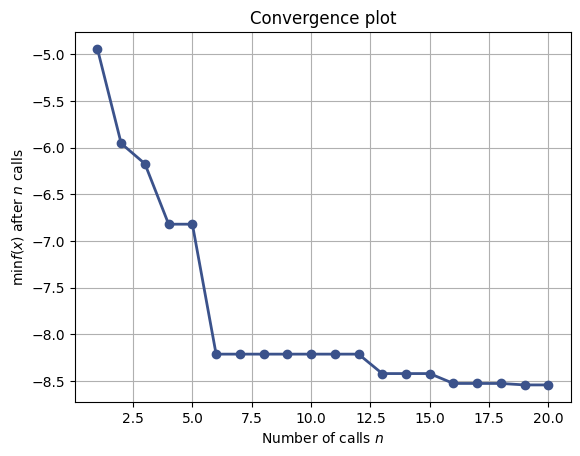

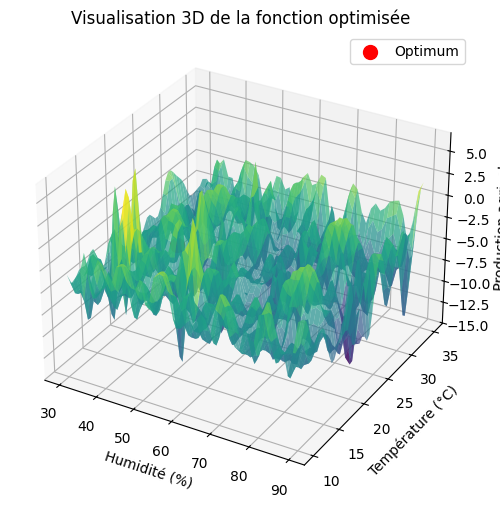

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from sklearn.gaussian_process import GaussianProcessRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Chargement des données
url = r"C:\Users\babou\Desktop\M1_OIVM\ATDN\S2\TP\TP3\tp2_atdn_donnees.csv"
df = pd.read_csv(url)
print(df.columns)

# Sélection des variables pertinentes
X = df[['Humidité (%)', 'Température (°C)']].values
y = df['Rendement agricole (t/ha)'].values

# Entraînement du modèle de processus pour approximer la fonction de rendement
gpr = GaussianProcessRegressor(random_state=42)
gpr.fit(X, y)

# Définition de la fonction objective basée sur le modèle entraîné
def production_agricole(params):
    humidite, temperature = params
    prediction = gpr.predict([[humidite, temperature]])
    return -prediction[0]  # On minimise l'inverse du rendement pour maximiser la production

# Définition de l'espace de recherche
space = [Real(df['Humidité (%)'].min(), df['Humidité (%)'].max(), name='humidité'),
         Real(df['Température (°C)'].min(), df['Température (°C)'].max(), name='température')]

# Application de l'optimisation bayésienne
res = gp_minimize(production_agricole, space, n_calls=20, random_state=42)

# Affichage des résultats
rendement_optimal = -production_agricole(res.x)  # pour remettre le bon signe
print("Meilleures conditions trouvées :")
print(f"Humidité = {res.x[0]:.2f} %")
print(f"Température = {res.x[1]:.2f} °C")
print(f"Rendement agricole optimal = {rendement_optimal:.2f} t/ha")

# Visualisation du processus d'optimisation
plot_convergence(res)
plt.show()

# Visualisation 3D de la fonction optimisée
humidite_vals = np.linspace(df['Humidité (%)'].min(), df['Humidité (%)'].max(), 50)
temperature_vals = np.linspace(df['Température (°C)'].min(), df['Température (°C)'].max(), 50)
H, T = np.meshgrid(humidite_vals, temperature_vals)
Z = np.array([production_agricole([h, t]) for h, t in zip(np.ravel(H), np.ravel(T))]).reshape(H.shape)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(H, T, Z, cmap='viridis', alpha=0.7)
ax.scatter(res.x[0], res.x[1], production_agricole(res.x), color='red', s=100, label='Optimum')
ax.set_xlabel('Humidité (%)')
ax.set_ylabel('Température (°C)')
ax.set_zlabel('Production agricole')
ax.set_title('Visualisation 3D de la fonction optimisée')
plt.legend()
plt.show()






In [26]:
# Préparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définition de la fonction objective pour l'optimisation bayésienne
def rf_objective(params):
    n_estimators, max_depth = params
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse  # Pour minimiser l'erreur quadratique moyenne

# Définition de l'espace de recherche
space = [
    Integer(10, 100, name='n_estimators'),
    Integer(1, 20, name='max_depth')
]

# Application de l'optimisation bayésienne
res_rf = gp_minimize(rf_objective, space, n_calls=20, random_state=42)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres ( avec l'optimisation bayésienne) pour Random Forest :")
print(f"n_estimators = {res_rf.x[0]}")
print(f"max_depth = {res_rf.x[1]}")

# Meilleurs hyperparamètres trouvés par l'optimisation bayésienne
bayesian_best_params = {'n_estimators': res_rf.x[0], 'max_depth': res_rf.x[1]}

# Entraînement du modèle avec les meilleurs hyperparamètres de l'optimisation bayésienne
bayesian_model = RandomForestRegressor(n_estimators=bayesian_best_params['n_estimators'],
                                       max_depth=bayesian_best_params['max_depth'], random_state=42)
bayesian_model.fit(X_train, y_train)

# Prédictions et calcul de l'erreur quadratique moyenne
bayesian_pred = bayesian_model.predict(X_test)
bayesian_mse = mean_squared_error(y_test, bayesian_pred)
print(f"Erreur quadratique moyenne (Optimisation Bayésienne) : {bayesian_mse:.4f}")

Meilleurs hyperparamètres ( avec l'optimisation bayésienne) pour Random Forest :
n_estimators = 50
max_depth = 3
Erreur quadratique moyenne (Optimisation Bayésienne) : 0.8697


In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

# Paramètres pour Grid Search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15, 20]
}

# Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f"Meilleurs hyperparamètres (Grid Search) : {grid_search.best_params_}")

# Meilleurs hyperparamètres trouvés par Grid Search
grid_best_params = grid_search.best_params_

# Entraînement du modèle avec les meilleurs hyperparamètres de Grid Search
grid_model = RandomForestRegressor(n_estimators=grid_best_params['n_estimators'], 
                                   max_depth=grid_best_params['max_depth'], random_state=42)
grid_model.fit(X_train, y_train)

# Prédictions et calcul de l'erreur quadratique moyenne
grid_pred = grid_model.predict(X_test)
grid_mse = mean_squared_error(y_test, grid_pred)
print(f"Erreur quadratique moyenne (Grid Search) : {grid_mse:.4f}")

# Random Search
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20)
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
print(f"Meilleurs hyperparamètres (Random Search) : {random_search.best_params_}")

# Meilleurs hyperparamètres trouvés par Random Search
random_best_params = random_search.best_params_

# Entraînement du modèle avec les meilleurs hyperparamètres de Random Search
random_model = RandomForestRegressor(n_estimators=random_best_params['n_estimators'],
                                     max_depth=random_best_params['max_depth'], random_state=42)
random_model.fit(X_train, y_train)

# Prédictions et calcul de l'erreur quadratique moyenne
random_pred = random_model.predict(X_test)
random_mse = mean_squared_error(y_test, random_pred)
print(f"Erreur quadratique moyenne (Random Search) : {random_mse:.4f}")



Meilleurs hyperparamètres (Grid Search) : {'max_depth': 5, 'n_estimators': 50}
Erreur quadratique moyenne (Grid Search) : 0.8981
Meilleurs hyperparamètres (Random Search) : {'max_depth': 4, 'n_estimators': 113}
Erreur quadratique moyenne (Random Search) : 0.8915


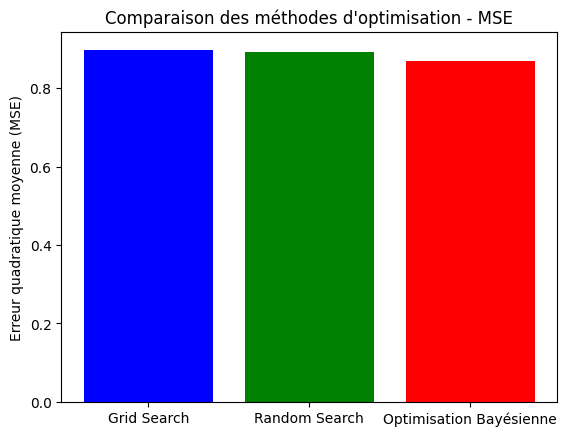

In [28]:
methods = ['Grid Search', 'Random Search', 'Optimisation Bayésienne']
mse_values = [grid_mse, random_mse, bayesian_mse]

plt.bar(methods, mse_values, color=['blue', 'green', 'red'])
plt.title("Comparaison des méthodes d'optimisation - MSE")
plt.ylabel("Erreur quadratique moyenne (MSE)")
plt.show()


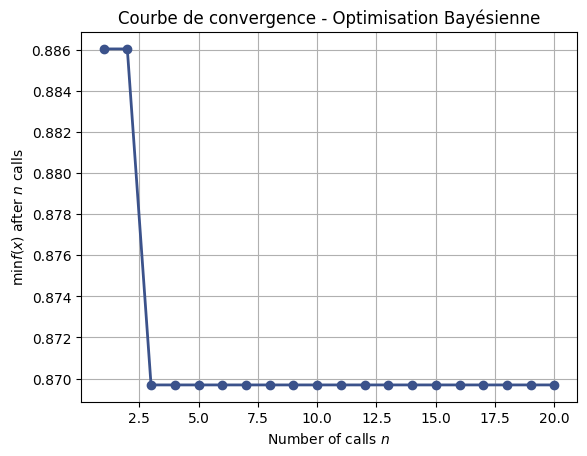

In [29]:
# Visualisation de la courbe de convergence
plot_convergence(res_rf)
plt.title("Courbe de convergence - Optimisation Bayésienne")
plt.show()


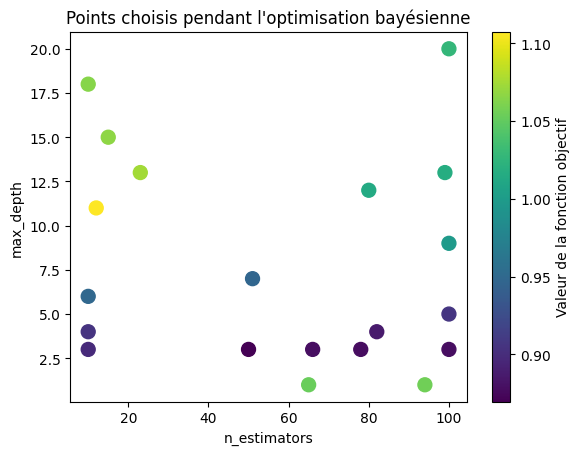

In [20]:
# Visualisation des points choisis pendant l'optimisation
x_vals = np.array(res_rf.x_iters)
y_vals = np.array(res_rf.func_vals)

# Plot des points choisis
plt.scatter(x_vals[:, 0], x_vals[:, 1], c=y_vals, cmap='viridis', marker='o', s=100)
plt.colorbar(label='Valeur de la fonction objectif')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title("Points choisis pendant l'optimisation bayésienne")
plt.show()


c:\Users\babou\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


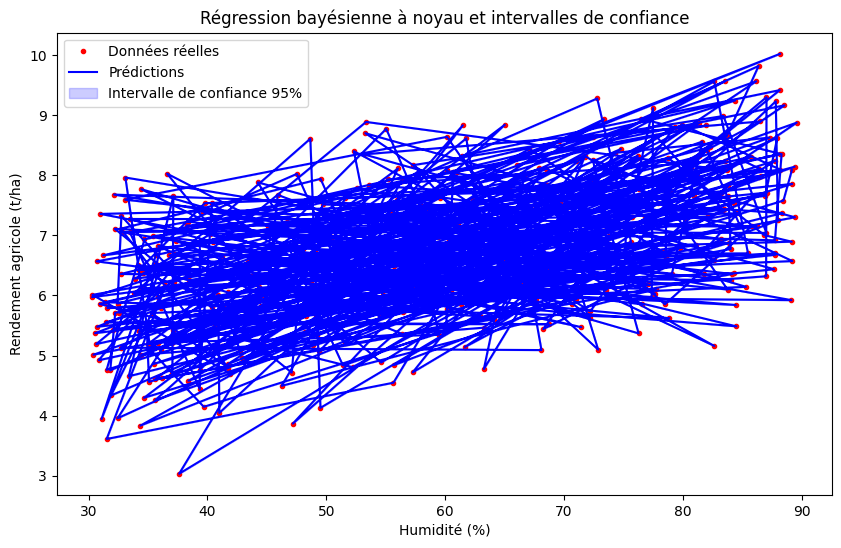

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Définition du noyau : on choisi un noyau RBF)
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# Création du modèle de régression bayésienne à noyau
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Entraînement du modèle
gp.fit(X, y)

# Prédictions avec intervalles de confiance
y_pred, sigma = gp.predict(X, return_std=True)

# Visualisation des prédictions et intervalles de confiance
plt.figure(figsize=(10, 6))
plt.plot(df['Humidité (%)'], y, 'r.', label='Données réelles')
plt.plot(df['Humidité (%)'], y_pred, 'b-', label='Prédictions')
plt.fill_between(df['Humidité (%)'], y_pred - 1.96*sigma, y_pred + 1.96*sigma, alpha=0.2, color='blue', label="Intervalle de confiance 95%")
plt.xlabel('Humidité (%)')
plt.ylabel('Rendement agricole (t/ha)')
plt.title('Régression bayésienne à noyau et intervalles de confiance')
plt.legend()
plt.show()


In [22]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# On suppose que les données climatiques sont dans les colonnes 'Température (°C)' et 'Humidité (%)'
X = df[['Température (°C)', 'Humidité (%)']].values
y = df['Type de sol']  # Cette colonne représente les classes (argileux, sableux, limoneux)

# On sépare les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Classification Bayésienne à noyau (avec un noyau RBF)
kernel = C(1.0) * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(X_train, y_train)

# 2. Classification avec SVM classique
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

# Prédictions
y_pred_gpc = gpc.predict(X_test)
y_pred_svm = svm.predict(X_test)

# Évaluation des modèles
print("Classification Bayésienne à noyau (GPC) - Rapport de classification :")
print(classification_report(y_test, y_pred_gpc))

print("SVM classique - Rapport de classification :")
print(classification_report(y_test, y_pred_svm))

# Matrices de confusion
print("Matrice de confusion (GPC) :")
print(confusion_matrix(y_test, y_pred_gpc))

print("Matrice de confusion (SVM) :")
print(confusion_matrix(y_test, y_pred_svm))


Classification Bayésienne à noyau (GPC) - Rapport de classification :
              precision    recall  f1-score   support

    Argileux       0.34      1.00      0.51        51
    Limoneux       0.00      0.00      0.00        51
     Sableux       0.00      0.00      0.00        48

    accuracy                           0.34       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.12      0.34      0.17       150

SVM classique - Rapport de classification :
              precision    recall  f1-score   support

    Argileux       0.34      1.00      0.51        51
    Limoneux       0.00      0.00      0.00        51
     Sableux       0.00      0.00      0.00        48

    accuracy                           0.34       150
   macro avg       0.11      0.33      0.17       150
weighted avg       0.12      0.34      0.17       150

Matrice de confusion (GPC) :
[[51  0  0]
 [51  0  0]
 [48  0  0]]
Matrice de confusion (SVM) :
[[51  0  0]
 [51  0  0]
 [48 

c:\Users\babou\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\babou\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\babou\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Probabilités des classes pour une observation :
[0.36156269 0.32666946 0.31176785]


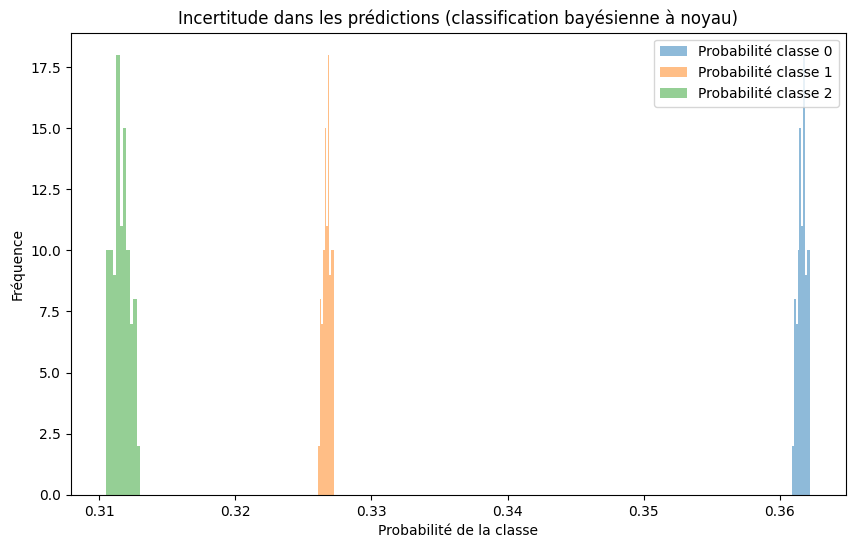

In [30]:
# Visualisation des probabilités pour chaque classe
y_prob = gpc.predict_proba(X_test)

# Affichage des probabilités pour une observation
print("Probabilités des classes pour une observation :")
print(y_prob[0])

# Visualisation des probabilités de la classe prédite
plt.figure(figsize=(10, 6))
plt.hist(y_prob[:, 0], bins=10, alpha=0.5, label='Probabilité classe 0')
plt.hist(y_prob[:, 1], bins=10, alpha=0.5, label='Probabilité classe 1')
plt.hist(y_prob[:, 2], bins=10, alpha=0.5, label='Probabilité classe 2')
plt.legend(loc='upper right')
plt.xlabel('Probabilité de la classe')
plt.ylabel('Fréquence')
plt.title('Incertitude dans les prédictions (classification bayésienne à noyau)')
plt.show()


In [105]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.metrics import classification_report
import numpy as np


# Définition les noyaux bayésiens
kernel_rbf = RBF(length_scale=1.0)  # Noyau RBF (Gaussien)
kernel_linear = DotProduct(sigma_0=1.0)  # Noyau linéaire
kernel_poly = DotProduct(sigma_0=2.0)  # Noyau polynomial

# Teste de chaque noyau
kernels = {
    "RBF": kernel_rbf,
    "Linéaire": kernel_linear,
    "Polynomial": kernel_poly
}

for name, kernel in kernels.items():
    print(f"\nTest du noyau : {name}")
    
    # Initialisation et entraînement du classifieur bayésien
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
    gpc.fit(X_train, y_train)

    # Prédictions
    y_pred = gpc.predict(X_test)

    # Résultats
    print(classification_report(y_test, y_pred))



Test du noyau : RBF
              precision    recall  f1-score   support

           0       0.29      0.08      0.12        26
           1       0.33      0.38      0.36        21
           2       0.17      0.38      0.24        13

    accuracy                           0.25        60
   macro avg       0.26      0.28      0.24        60
weighted avg       0.28      0.25      0.23        60


Test du noyau : Linéaire
              precision    recall  f1-score   support

           0       0.36      0.19      0.25        26
           1       0.37      0.33      0.35        21
           2       0.19      0.38      0.25        13

    accuracy                           0.28        60
   macro avg       0.30      0.30      0.28        60
weighted avg       0.32      0.28      0.29        60


Test du noyau : Polynomial
              precision    recall  f1-score   support

           0       0.36      0.19      0.25        26
           1       0.37      0.33      0.35        21
